In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import gc
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json

In [3]:
gc.collect()
tf.keras.backend.clear_session()


In [4]:
DATA_DIR = "../data/train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 4

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.4, 1.6],
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [7]:
print("📊 Model Summary:")
model.summary()

📊 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,854,886 (91.00 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
checkpoint_cb = ModelCheckpoint("../models/resnet50/best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\n✅ Epoch {epoch+1} complete — Accuracy: {logs['accuracy']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

callbacks = [checkpoint_cb, earlystop_cb, EpochLogger()]


Apple___Apple_scab: 1613 images
Apple___Black_rot: 1590 images
Apple___Cedar_apple_rust: 1408 images
Apple___healthy: 1607 images
Blueberry___healthy: 1453 images
Cherry_(including_sour)___Powdery_mildew: 1347 images
Cherry_(including_sour)___healthy: 1461 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1314 images
Corn_(maize)___Common_rust_: 1526 images
Corn_(maize)___Northern_Leaf_Blight: 1527 images
Corn_(maize)___healthy: 1488 images
Grape___Black_rot: 1511 images
Grape___Esca_(Black_Measles): 1536 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1378 images
Grape___healthy: 1354 images
Orange___Haunglongbing_(Citrus_greening): 1608 images
Peach___Bacterial_spot: 1471 images
Peach___healthy: 1383 images
Pepper,_bell___Bacterial_spot: 1531 images
Pepper,_bell___healthy: 1591 images
Potato___Early_blight: 1552 images
Potato___Late_blight: 1552 images
Potato___healthy: 1460 images
Raspberry___healthy: 1425 images
Soybean___healthy: 1618 images
Squash___Powdery_mildew: 13

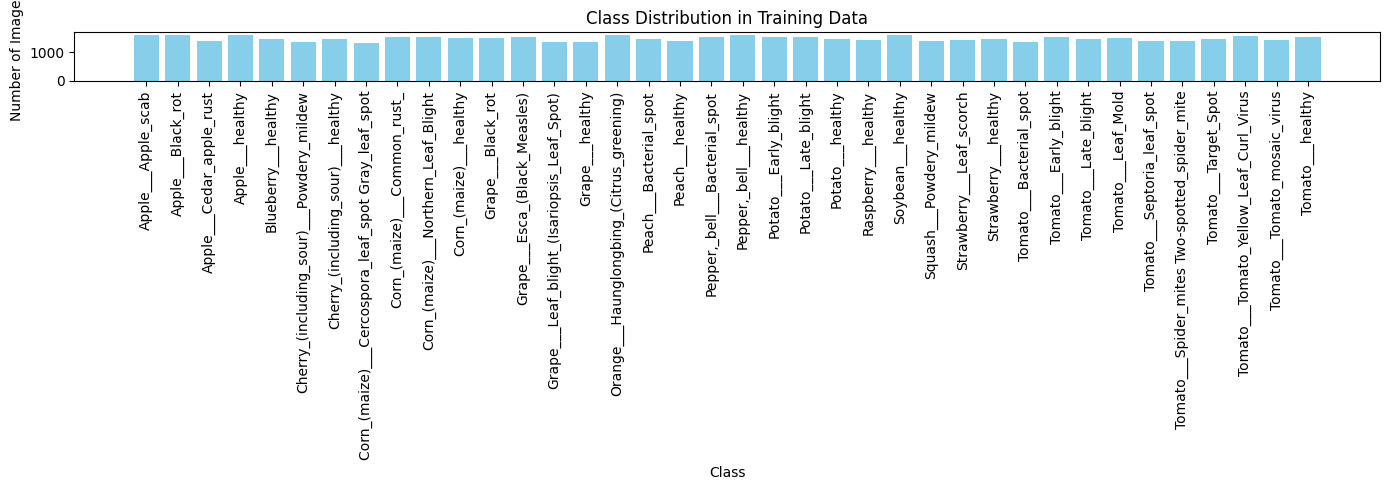

In [10]:
import numpy as np
import matplotlib.pyplot as plt


labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())
class_counts = np.bincount(labels)


for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} images")


plt.figure(figsize=(14, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig("../visualizations/class_distribution_resnet50.png")
plt.show()


In [ ]:
print("\n🚀 Starting training using ResNet50...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

In [ ]:
model.save("../models/resnet50/final_model.h5")

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../visualizations/training_accuracy_resnet50.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../visualizations/training_loss_resnet50.png")
plt.show()

print("\n✅ Training with ResNet50 complete and saved.") 